<h2><center><b><i>Cluster bomb</b></i>: Uncovering Patterns in Terrorist Group Beliefs and Attacks</center></h2>

#### **COM-480: Data Visualization**

**Team**: Alexander Sternfeld, Silvia Romanato & Antoine Bonnet

**Dataset**: [Global Terrorism Database (GTD)](https://www.start.umd.edu/gtd/) 

**Additional dataset**: [Profiles of Perpetrators of Terrorism in the United States (PPTUS)](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl%3A1902.1/17702)

## **Terrorist groups**

 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from load_data import *

pd.set_option('display.max_columns', None)

GTD = load_GTD()
PPTUS_data, PPTUS_sources = load_PPTUS()


GTD pickle file found, loading...
PPTUS pickle files found, loading...


### Ideologies

In [2]:
# Rename some of the columns
PPTUS_data.rename(columns={'DOM_I': 'dominant_ideology', 'I_ETHNO': 'ethno_nationalist',  'I_REL': 'religious', 'I_RACE':  'racist',
                            'I_LEFT': 'extreme_left', 'I_RIGHT':  'extreme_right', 'G_POL_1':  'politic_reasons', 'G_SOC_1':  'social_reasons',
                            'G_ECO_1': 'economic_reasons', 'G_REL_1':  'religious_reasons'}, inplace=True)


In [3]:
# Print number of rows where gname is not "Unknown"
print("-"*30, "GTD", "-"*30)	
print("Number of attacks where group name is not Unknown: ", len(GTD[GTD.gname != "Unknown"]))
print("Number of distinct groups in GTD:", len(GTD.gname.unique())-1)

print("")
print("-"*30, "PPTUS", "-"*30)
known_groups = PPTUS_data['ORGNAME'].unique()

print("Number of known groups: ", len(known_groups))
print("Number of attacks executed by a known group: ", len(GTD[GTD.gname.isin(known_groups)]))

------------------------------ GTD ------------------------------
Number of attacks where group name is not Unknown:  120991
Number of distinct groups in GTD: 3766

------------------------------ PPTUS ------------------------------
Number of known groups:  145
Number of attacks executed by a known group:  7131


In [4]:
# Retain only attacks executed by a known group
GTD_gattacks = GTD[GTD.gname.isin(known_groups)]

# Merge GTD_gattacks with PPTUS_data
GTD_gattacks = pd.merge(GTD_gattacks, PPTUS_data, left_on='gname', right_on='ORGNAME', how='left')

In [5]:
# Make a dataframe with as rows the distinct ideologies and as a column the number of attacks
ideologies = {1: "Extreme Right Wing", 2: "Extreme Left Wing",
              3: "Religious", 4: "Ethno-nationalist/separist", 5: "Single issue"}

ideology_counts = pd.DataFrame(columns=['ideology', 'count'])
for ideology in ideologies:
    ideology_counts = ideology_counts.append({'ideology': ideologies[ideology], 'count': len(
        GTD_gattacks[GTD_gattacks.dominant_ideology == ideology])}, ignore_index=True)

ideology_counts.set_index('ideology', inplace=True)

ideology_counts

,count
ideology,
Extreme Right Wing,61
Extreme Left Wing,430
Religious,2722
Ethno-nationalist/separist,3495
Single issue,415


## Group analysis

#### Ideas for plots regarding groups (Alex)

**Origin of the group**
* Use first known and last known attack data of group: see based on the ideology which groups last longer
* Do something with the founding philosophy (PHIL) of the groups. This is a text variable.

**Organization of groups**
* structure of the organization: STRUC_1 (hierarchical), STRUC_2 (network), STRUC_3 (umbrella), STRUC_4 (movement), STRUC_OTH
* Recruitment strategies: REC_1 (net), REC_2 (funnel), REC_3 (infection), REC_4 (seed crystal), REC_5 (self-recruitment), REC_OTH (other). Medium of recruitment: MREC_1 (direct), MREC_2 (indirect)
* Financing: FINS_1 (state sponsorship), FINS_2 (illegal activities), FINS_3 (donations), FINS_4 (front companies), FINS_5 (self-funded), FINS_OTH (other)

**Strategies of the groups**
* Target types, attack types, number of casualties.

#### Ideas for plots regarding ideologies (Silvia)

**Overview of ideologies**
* Dive into main- and sub-ideologies

**Motivations of different ideologies**
* Have a look at header "Major goals" in PPT_US

**Evolvement over time**
* How have the main/sub ideologies evolved over time?



### Group organization

In [6]:
#----------------------Group structure----------------------#
# For each ideology, print percentages where STRUC_1 is 1, STRUC_2 is 1, STRUC_3 is 1, STRUC_4 is 1, STRUC_OTH is 1

# initialize a dictionary where the key is (ideology, structure) and the value is the percentage
ideology_structure = {}

for i in range(5):
    ideology = ideologies[i+1]
    subset = GTD_gattacks[GTD_gattacks.dominant_ideology == i+1]
    total_known_structure = len(subset[subset.STRUC_1 != -99])
    for j in range(5):
        structure = j+1
        if j != 4:
            ideology_structure[(ideology, structure)] = len(
                subset[subset['STRUC_'+str(structure)] == 1])/total_known_structure
        if j ==4:
            ideology_structure[(ideology, structure)] = len(
            subset[subset['STRUC_OTH'] == 1])/total_known_structure

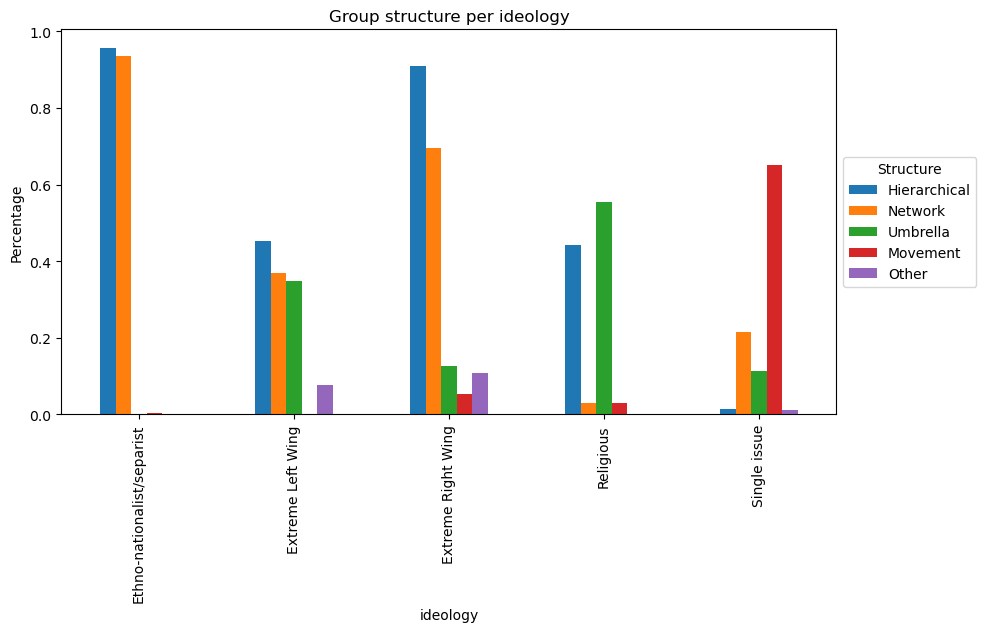

In [7]:
# Now make a grouped bar chart with the percentages
# Make a dataframe with the percentages
ideology_structure_df = pd.DataFrame(columns=['ideology', 'structure', 'percentage'])
for key in ideology_structure:
    ideology_structure_df = ideology_structure_df.append({'ideology': key[0], 'structure': key[1], 'percentage': ideology_structure[key]}, ignore_index=True)

ideology_structure_df.set_index(['ideology', 'structure'], inplace=True)

# Now make a grouped bar chart with the percentages. The chart should not be stacked, the bars should be next to each other
ideology_structure_df.unstack().plot(kind='bar', stacked=False, figsize=(10, 5))
# Change the legend. The legend should be outside the plot, for each color we should display the structure (1: Hierarchical, 2: Networked, 3: Cell-like, 4: Fragmented, 5: Other)
# Change the content of the legend
plt.legend(title="Structure", loc='center left', bbox_to_anchor=(1, 0.5), labels=['Hierarchical', 'Network', 'Umbrella', 'Movement', 'Other'])
plt.title("Group structure per ideology")
plt.ylabel("Percentage")
plt.show()

In [8]:
# Make a csv with the columns ideology, Hierarchical, Network, Umbrella, Movement, Other. The values should be the percentages.

# Alter in the dataframe the values of the structure column. The numbers should be replaced by the names of the structures
ideology_structure_df.reset_index(inplace=True)
ideology_structure_df['structure'] = ideology_structure_df['structure'].replace({1: 'Hierarchical', 2: 'Network', 3: 'Umbrella', 4: 'Movement', 5: 'Other'})
ideology_structure_df.set_index(['ideology', 'structure'], inplace=True)

# Pivot the dataframe
ideology_structure_df = ideology_structure_df.pivot_table(index='ideology', columns='structure', values='percentage')

# Save the dataframe to a csv
ideology_structure_df.to_csv('../data/ideology_structure.csv')



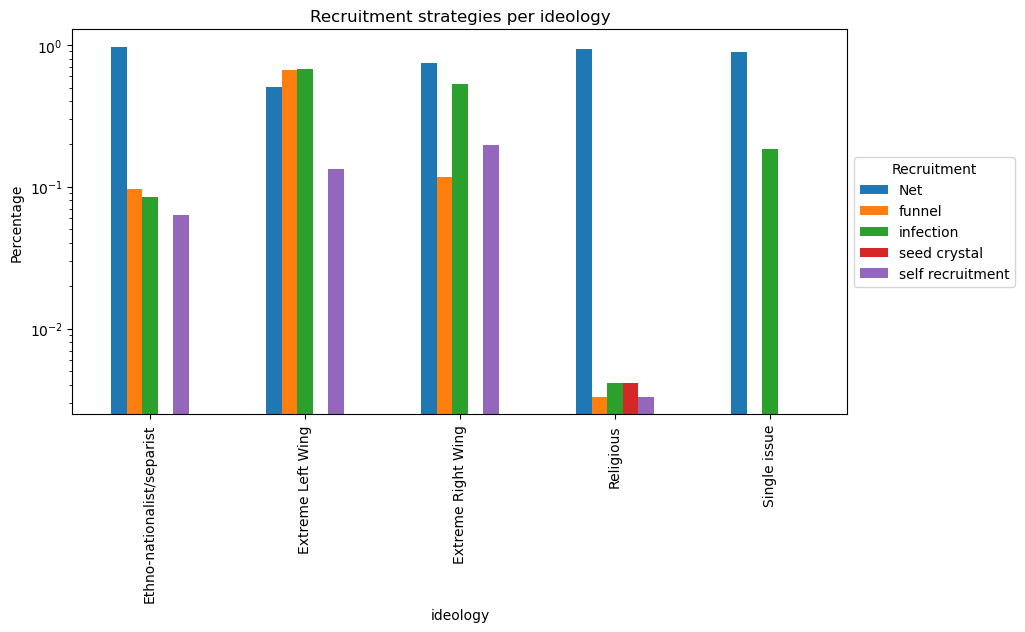

In [9]:
#---------------------Recruitment strategies---------------------#
# Do the same as before, but now for REC_1, REC_2, REC_3, REC_4, REC_5, REC_OTH
# initialize a dictionary where the key is (ideology, recruitment) and the value is the percentage
ideology_recruitment = {}

for i in range(5):
    ideology = ideologies[i+1]
    subset = GTD_gattacks[GTD_gattacks.dominant_ideology == i+1]
    total_known_recruitment = len(subset[subset.REC_1 != -99])
    for j in range(5):
        recruitment = j+1
        if j != 4:
            ideology_recruitment[(ideology, recruitment)] = len(
                subset[subset['REC_'+str(recruitment)] == 1])/total_known_recruitment
        if j ==4:
            ideology_recruitment[(ideology, recruitment)] = len(
            subset[subset['REC_OTH'] == 1])/total_known_recruitment

# Now make a grouped bar chart with the percentages
# Make a dataframe with the percentages
ideology_recruitment_df = pd.DataFrame(columns=['ideology', 'recruitment', 'percentage'])
for key in ideology_recruitment:
    ideology_recruitment_df = ideology_recruitment_df.append({'ideology': key[0], 'recruitment': key[1], 'percentage': ideology_recruitment[key]}, ignore_index=True)

ideology_recruitment_df.set_index(['ideology', 'recruitment'], inplace=True)

# Now make a grouped bar chart with the percentages. The chart should not be stacked, the bars should be next to each other
ideology_recruitment_df.unstack().plot(kind='bar', stacked=False, figsize=(10, 5))
# Change the legend. The legend should be outside the plot, for each color we should display the recruitment (1: Coercion, 2: Material Incentive, 3: Social Network, 4: Ideological, 5: Other)
# Change the content of the legend
plt.legend(title="Recruitment", loc='center left', bbox_to_anchor=(1, 0.5), labels=['Net', 'funnel', 'infection', 'seed crystal', 'self recruitment', 'Other'])
plt.title("Recruitment strategies per ideology")
plt.ylabel("Percentage")
# log y axis
plt.yscale('log')
plt.show()


In [10]:
# Make a csv with the columns ideology, Net, funnel, infection, seed crystal, self recruitment, Other. The values should be the percentages.

# Alter in the dataframe the values of the recruitment column. The numbers should be replaced by the names of the recruitment
ideology_recruitment_df.reset_index(inplace=True)
ideology_recruitment_df['recruitment'] = ideology_recruitment_df['recruitment'].replace({1: 'Net', 2: 'funnel', 3: 'infection', 4: 'seed crystal', 5: 'self recruitment', 6: 'Other'})
ideology_recruitment_df.set_index(['ideology', 'recruitment'], inplace=True)

# Pivot the dataframe
ideology_recruitment_df = ideology_recruitment_df.pivot_table(index='ideology', columns='recruitment', values='percentage')

# Save the dataframe to a csv
ideology_recruitment_df.to_csv('../data/ideology_recruitment.csv')

## Specific group analysis

In [11]:
# Get the groups of interest
taliban_attacks = GTD_gattacks[GTD_gattacks.gname ==
                               "Tehrik-i-Taliban Pakistan (TTP)"]
mek_attacks = GTD_gattacks[GTD_gattacks.gname == "Mujahedin-e Khalq (MEK)"]
IRA_attacks = GTD_gattacks[GTD_gattacks.gname == "Irish Republican Army (IRA)"]

#### Differences in targets

In [12]:
# import plotly
import plotly.graph_objects as go
import plotly.express as px

# Make an interactive graph, that shows the different target types ('targtype1_txt') for the groups of interest
# Use percentages instead of absolute numbers
# Use a stacked bar chart, use the categories "Military", "Government (General)", "Police", "Private Citizens & Property", "Business" and "Other"

types = ['Military', 'Government (General)', 'Police', 'Private Citizens & Property', 'Business', 'Other']
# Make a dataframe with the target types and the percentages
target_types = pd.DataFrame(columns=['target_type', 'percentage', 'group'])
for group in [taliban_attacks, mek_attacks, IRA_attacks]:
    for type in types:
        target_types = target_types.append({'target_type': type, 'percentage': len(group[group.targtype1_txt == type]) / len(group) * 100, 'group': group.gname.iloc[0]}, ignore_index=True)

# Make a stacked bar chart, each bar represents a group, the different colors represent the different target types
fig = px.bar(target_types, x="group", y="percentage", color="target_type", barmode="stack")
fig.show()

# Save the figure as a html file to display on a website, save in the folder 'plots'
fig.write_html("../plots/group_target_types.html")


### Ideas for plots

* For each group, show how the number of attacks changed over time (ideally on a map?)
